In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import pandas_ta as ta
import matplotlib.pyplot as plt
from datetime import date
plt.style.use('fivethirtyeight')
yf.pdr_override()

In [2]:
stocksymbols = ['AXISBANK.NS']
startdate = date(2017,8,4)
end_date = date.today()
print(end_date)
def getMyPortfolio(stocks = stocksymbols ,start = startdate , end = end_date):
    data = web.get_data_yahoo(stocks , start = start ,end= end )
    return data

2022-12-28


In [3]:
data = getMyPortfolio(stocksymbols)
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-21,953.099976,958.900024,928.000000,932.299988,932.299988,8368960
2022-12-22,936.000000,936.000000,912.950012,919.549988,919.549988,9202717
2022-12-23,912.000000,917.250000,904.000000,906.599976,906.599976,6371695
2022-12-26,908.000000,932.950012,905.099976,928.700012,928.700012,4764440
2022-12-27,932.450012,937.799988,922.599976,932.200012,932.200012,3346083


In [4]:
data['SMA 30'] = ta.sma(data['Close'],30)
data['SMA 100'] = ta.sma(data['Close'],100)

In [5]:
def buy_sell(data):
    signalBuy = []
    signalSell = []
    position = False 

    for i in range(len(data)):
        if data['SMA 30'][i] > data['SMA 100'][i]:
            if position == False :
                signalBuy.append(data['Adj Close'][i])
                signalSell.append(np.nan)
                position = True
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        elif data['SMA 30'][i] < data['SMA 100'][i]:
            if position == True:
                signalBuy.append(np.nan)
                signalSell.append(data['Adj Close'][i])
                position = False
            else:
                signalBuy.append(np.nan)
                signalSell.append(np.nan)
        else:
            signalBuy.append(np.nan)
            signalSell.append(np.nan)
    return pd.Series([signalBuy, signalSell])

In [6]:
data['Buy_Signal_price'], data['Sell_Signal_price'] = buy_sell(data)
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA 30,SMA 100,Buy_Signal_price,Sell_Signal_price
Date,,,,,,,,,,
2017-08-04,506.000000,510.799988,504.600006,508.100006,506.698517,4972811,NaN,NaN,NaN,NaN
2017-08-07,509.000000,511.799988,504.100006,505.799988,504.404816,5293884,NaN,NaN,NaN,NaN
2017-08-08,507.700012,510.950012,496.049988,499.450012,498.072357,8898560,NaN,NaN,NaN,NaN
2017-08-09,494.450012,498.649994,485.450012,486.950012,485.606842,7169705,NaN,NaN,NaN,NaN
2017-08-10,485.100006,494.149994,483.549988,485.500000,484.160828,10095387,NaN,NaN,NaN,NaN


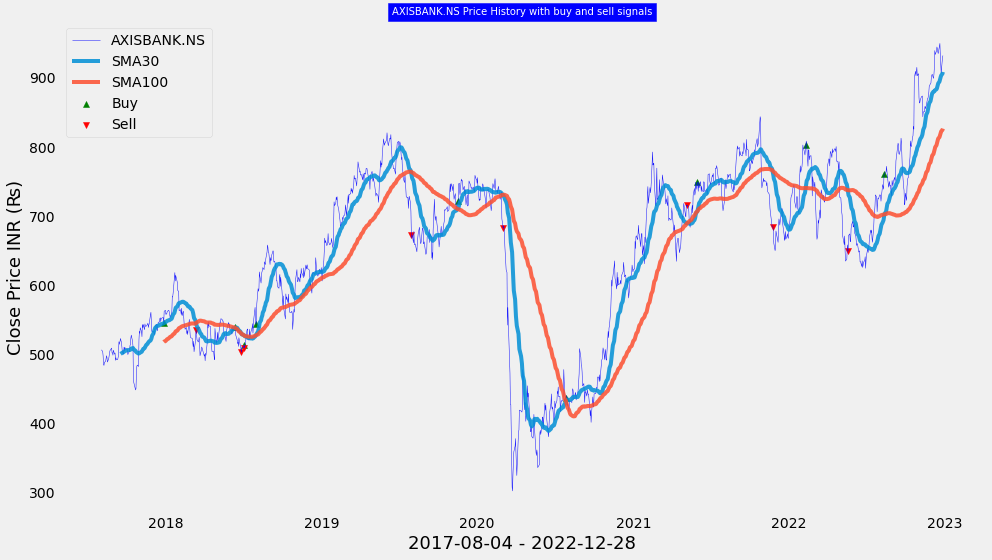

In [7]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(data['Adj Close'] , label = stocksymbols[0] ,linewidth=0.5, color='blue', alpha = 0.9)
ax.plot(data['SMA 30'], label = 'SMA30', alpha = 0.85)
ax.plot(data['SMA 100'], label = 'SMA100' , alpha = 0.85)
ax.scatter(data.index , data['Buy_Signal_price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
ax.scatter(data.index , data['Sell_Signal_price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
ax.set_title(stocksymbols[0] + " Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
ax.set_xlabel(f'{startdate} - {end_date}' ,fontsize=18)
ax.set_ylabel('Close Price INR (₨)' , fontsize=18)
legend = ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

In [8]:
macd = ta.macd(data['Close'])
macd.tail()

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,
2022-12-21,20.309783,-0.504082,20.813865
2022-12-22,17.831737,-2.385703,20.217440
2022-12-23,14.653988,-4.450762,19.104749
2022-12-26,13.760267,-4.275586,18.035853
2022-12-27,13.182448,-3.882723,17.065172


In [9]:
data = pd.concat([data, macd], axis=1).reindex(data.index)

In [10]:
def MACD_Strategy(df, risk):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(df)):
        if df['MACD_12_26_9'][i] > df['MACDs_12_26_9'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['Adj Close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['MACD_12_26_9'][i] < df['MACDs_12_26_9'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['Adj Close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['Adj Close'][i] < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['Adj Close'][i] < df['Adj Close'][i - 1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    data['MACD_Buy_Signal_price'] = MACD_Buy
    data['MACD_Sell_Signal_price'] = MACD_Sell


In [11]:
MACD_strategy = MACD_Strategy(data, 0.025)
MACD_strategy

In [17]:
def MACD_color(data):
    MACD_color = []
    for i in range(0, len(data)):
        if data['MACDh_12_26_9'][i] > data['MACDh_12_26_9'][i - 1]:
            MACD_color.append(True)
        else:
            MACD_color.append(False)
    return MACD_color

data['positive'] = MACD_color(data)

In [18]:
import plotly.express as px


px.line(x = data.index, y = data['MACD_Buy_Signal_price'])

In [ ]:
plt.rcParams.update({'font.size': 10})
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot('Adj Close',data=data, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.set_ylabel('MACD', fontsize=8)
ax2.plot('MACD_12_26_9', data=data, label='MACD', linewidth=0.5, color='blue')
ax2.plot('MACDs_12_26_9', data=data, label='signal', linewidth=0.5, color='red')
ax2.bar(data.index,'MACDh_12_26_9', data=data, label='Volume', color=data.positive.map({True: 'g', False: 'r'}),width=1,alpha=0.8)
ax2.axhline(0, color='black', linewidth=0.5, alpha=0.5)
ax2.grid()
plt.show()


In [ ]:
def bb_strategy(data):
    bbBuy = []
    bbSell = []
    position = False
    bb = ta.bbands(data['Adj Close'], length=20,std=2)
    data = pd.concat([data, bb], axis=1).reindex(data.index)

    for i in range(len(data)):
        if data['Adj Close'][i] < data['BBL_20_2.0'][i]:
            if position == False :
                bbBuy.append(data['Adj Close'][i])
                bbSell.append(np.nan)
                position = True
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        elif data['Adj Close'][i] > data['BBU_20_2.0'][i]:
            if position == True:
                bbBuy.append(np.nan)
                bbSell.append(data['Adj Close'][i])
                position = False #To indicate that I actually went there
            else:
                bbBuy.append(np.nan)
                bbSell.append(np.nan)
        else :
            bbBuy.append(np.nan)
            bbSell.append(np.nan)

    data['bb_Buy_Signal_price'] = bbBuy
    data['bb_Sell_Signal_price'] = bbSell

    return data


In [ ]:
#storing the function
data = bb_strategy(data)

In [ ]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(stocksymbols[0], fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price in ₨')
ax1.plot(data['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['bb_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['bb_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(data['BBM_20_2.0'], label='Middle', color='blue', alpha=0.35) #middle band
ax2.plot(data['BBU_20_2.0'], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(data['BBL_20_2.0'], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(data.index, data['BBL_20_2.0'], data['BBU_20_2.0'], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()
